# **Homework 3 Due on Friday November 10 23h59**


**Copy your Colab link here:**
https://colab.research.google.com/drive/1dOnxOY4YrJLxSmsjaRi3Xe2UH3_6z5xl?usp=sharing





# **Problem 0: Moving the lab to your folder**

Duplicate this notebook (as you won't have write permission to this) to your Google Drive.
This can be done by clicking on *File Menu - Save a copy in Drive*

Run to mount your google drives:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Your drive would be accessed as '/content/drive/MyDrive' for Colab. We suggest putting your data and creating a 'results' folder somewhere in the drive. The 'results' folder could be used for storing the required outputs.   

In [61]:
# example goes like:
DataPath  = '/content/drive/MyDrive/lab6/HW3_data'
ResultPath = '/content/drive/MyDrive/YOUR_PATH_HERE/results'

Then, load all the imports you plan to use later;
just do not use those built-in functions which directly solve the problem.

For example, you need to write GMM algorithms based on EM by yourself. If you are not sure whether the ones you want to import meet the requirement, you are always welcome to send us an email as usual.

In [66]:
# add the package here. Again do not use those built-in functions which directly
# solve the problem. If you are not sure whether the ones you want to import
# meet the requirement, you are always welcome to send us an email as usual.

import numpy as np
import os
import math
import random
from scipy.stats import multivariate_normal
!pip install numpy scikit-learn
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import beta
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import Lasso
from sklearn.mixture import GaussianMixture
from warnings import filterwarnings

# **Problem 1: GMMs for Speaker Recognition**



**Your mathematical derivations and the steps of the EM algorithm**

In [62]:
# Paths to training and testing data
train_path = DataPath + '/HW3_Problem_1/train'
test_path = DataPath + '/HW3_Problem_1/test'
utt2spk_path = DataPath + '/HW3_Problem_1/utt2spk'

speaker_mapping = {}
with open(utt2spk_path, 'r') as f:
    for line in f:
        filename, speaker_id = line.strip().split()
        speaker_mapping[filename] = speaker_id

# Load training data
train_data = {}
for file_name in os.listdir(train_path):
    file_path = os.path.join(train_path, file_name)
    data = np.genfromtxt(file_path)
    speaker_id = speaker_mapping[file_name]
    if speaker_id not in train_data:
        train_data[speaker_id] = []
    train_data[speaker_id].append(data)

# Load test data
test_data = {}
for file_name in os.listdir(test_path):
    file_path = os.path.join(test_path, file_name)
    data = np.genfromtxt(file_path)
    test_data[file_name] = data

for speaker_id, recordings in train_data.items():
    print(f"Speaker {speaker_id}: {len(recordings)} recordings")

Speaker 3424-m: 2 recordings
Speaker 4287-f: 2 recordings
Speaker 102147-m: 2 recordings
Speaker 106888-m: 2 recordings
Speaker 4177-m: 2 recordings
Speaker 101188-m: 2 recordings
Speaker 7722-f: 2 recordings
Speaker 103183-m: 2 recordings
Speaker 110667-m: 2 recordings
Speaker 2042-f: 2 recordings


# EM Algorithm Derivation for Gaussian Mixture Models

## Problem Setup

Given a dataset of MFCC vectors for speaker $j$:

$$
\mathbf{X}^{(j)} = \{ \mathbf{x}_1^{(j)}, \mathbf{x}_2^{(j)}, \ldots, \mathbf{x}_n^{(j)} \}, \quad \mathbf{x}_i^{(j)} \in \mathbb{R}^{20}
$$

We want to fit a Gaussian Mixture Model (GMM) with $K = 64$ components to the data. Each Gaussian component $k$ is parameterized by:

- Mixing coefficient $\pi_k^{(j)}$, where $\sum_{k=1}^{K} \pi_k^{(j)} = 1$.
- Mean vector $\boldsymbol{\mu}_k^{(j)} \in \mathbb{R}^{20}$.
- Diagonal covariance matrix $\boldsymbol{\Sigma}_k^{(j)}$.


## GMM Density Function

The GMM density function for speaker $j$ is:

$$
p(\mathbf{x}_i^{(j)}) = \sum_{k=1}^{K} \pi_k^{(j)} \mathcal{N}(\mathbf{x}_i^{(j)} \mid \boldsymbol{\mu}_k^{(j)}, \boldsymbol{\Sigma}_k^{(j)})
$$

where $\mathcal{N}(\mathbf{x} \mid \boldsymbol{\mu}, \boldsymbol{\Sigma})$ is the multivariate Gaussian distribution.


## Log-Likelihood of the Data

The log-likelihood of the data for speaker $j$ is:

$$
\log p(\mathbf{X}^{(j)} \mid \pi^{(j)}, \boldsymbol{\mu}^{(j)}, \boldsymbol{\Sigma}^{(j)}) = \sum_{i=1}^{n} \log \left( \sum_{k=1}^{K} \pi_k^{(j)} \mathcal{N}(\mathbf{x}_i^{(j)} \mid \boldsymbol{\mu}_k^{(j)}, \boldsymbol{\Sigma}_k^{(j)}) \right)
$$


## E-Step (Expectation Step)

Compute the responsibility $\gamma_{ik}^{(j)}$:

$$
\gamma_{ik}^{(j)} = \frac{\pi_k^{(j)} \mathcal{N}(\mathbf{x}_i^{(j)} \mid \boldsymbol{\mu}_k^{(j)}, \boldsymbol{\Sigma}_k^{(j)})}{\sum_{m=1}^{K} \pi_m^{(j)} \mathcal{N}(\mathbf{x}_i^{(j)} \mid \boldsymbol{\mu}_m^{(j)}, \boldsymbol{\Sigma}_m^{(j)})}
$$


## M-Step (Maximization Step)

Update the parameters $\pi_k^{(j)}$, $\boldsymbol{\mu}_k^{(j)}$, and $\boldsymbol{\Sigma}_k^{(j)}$:

- Update for the mixing coefficient:

$$
\pi_k^{(j)} = \frac{1}{n} \sum_{i=1}^{n} \gamma_{ik}^{(j)}
$$

- Update for the mean vector:

$$
\boldsymbol{\mu}_k^{(j)} = \frac{\sum_{i=1}^{n} \gamma_{ik}^{(j)} \mathbf{x}_i^{(j)}}{\sum_{i=1}^{n} \gamma_{ik}^{(j)}}
$$

- Update for the diagonal covariance matrix:

$$
\boldsymbol{\Sigma}_k^{(j)} = \text{diag}\left(\frac{\sum_{i=1}^{n} \gamma_{ik}^{(j)} (\mathbf{x}_i^{(j)} - \boldsymbol{\mu}_k^{(j)})^2}{\sum_{i=1}^{n} \gamma_{ik}^{(j)}}\right)
$$


## Convergence Check

Check for convergence of the log-likelihood:

$$
\left| \text{Log-likelihood}_{\text{new}} - \text{Log-likelihood}_{\text{old}} \right| < \epsilon
$$

where $\epsilon = 10^{-4}$ is the threshold for convergence.


**Your GMM coding algorithm**

In [65]:
class GaussianMixtureModel:
    def __init__(self, n_components=64, max_iters=20, tol=1e-4):

        self.n_components = n_components
        self.max_iters = max_iters
        self.tol = tol
        self.weights = None
        self.means = None
        self.covariances = None

    def initialize_params(self, X):

        n_samples, n_features = X.shape

        # Initialize means using K-Means clustering
        kmeans = KMeans(n_clusters=self.n_components, random_state=42).fit(X)
        self.means = kmeans.cluster_centers_

        # Initialize weights uniformly
        self.weights = np.full(self.n_components, 1 / self.n_components)

        # Initialize covariances as identity matrices with regularization
        self.covariances = np.array([
            np.cov(X.T) + 1e-6 * np.eye(n_features) for _ in range(self.n_components)
        ])

    def e_step(self, X):

        n_samples, _ = X.shape
        responsibilities = np.zeros((n_samples, self.n_components))

        # Calculate responsibilities for each component
        for k in range(self.n_components):
            responsibilities[:, k] = self.weights[k] * multivariate_normal.pdf(
                X, mean=self.means[k], cov=self.covariances[k]
            )

        # Normalize responsibilities across components
        responsibilities_sum = responsibilities.sum(axis=1, keepdims=True) + 1e-10
        responsibilities /= responsibilities_sum

        return responsibilities

    def m_step(self, X, responsibilities):

        n_samples, n_features = X.shape
        Nk = responsibilities.sum(axis=0)

        # Update weights
        self.weights = Nk / n_samples

        # Update means
        self.means = np.dot(responsibilities.T, X) / Nk[:, np.newaxis]

        # Update covariances
        for k in range(self.n_components):
            diff = X - self.means[k]
            self.covariances[k] = np.dot(responsibilities[:, k] * diff.T, diff) / Nk[k]
            # Regularize covariances to avoid singular matrix
            self.covariances[k].flat[::n_features + 1] += 1e-6

    def log_likelihood(self, X):

        n_samples, _ = X.shape
        log_likelihood = np.zeros((n_samples, self.n_components))

        # Calculate the log-likelihood for each component
        for k in range(self.n_components):
            log_likelihood[:, k] = (
                np.log(self.weights[k] + 1e-10) +
                multivariate_normal.logpdf(X, mean=self.means[k], cov=self.covariances[k])
            )

        # Use the log-sum-exp trick for numerical stability
        max_log = np.max(log_likelihood, axis=1, keepdims=True)
        stable_log_likelihood = max_log + np.log(np.sum(np.exp(log_likelihood - max_log), axis=1, keepdims=True))

        return np.sum(stable_log_likelihood)

    def fit(self, X):

        self.initialize_params(X)
        log_likelihoods = []

        for i in range(self.max_iters):
            # E-step
            responsibilities = self.e_step(X)

            # M-step
            self.m_step(X, responsibilities)

            # Calculate log-likelihood
            log_likelihood = self.log_likelihood(X)
            log_likelihoods.append(log_likelihood)

            # Check for convergence
            if i > 0 and abs(log_likelihood - log_likelihoods[-2]) < self.tol:
                print(f"Converged at iteration {i}")
                break

        return log_likelihoods

    def predict_log_likelihood(self, X):

        log_likelihoods = np.zeros((X.shape[0], self.n_components))

        # Calculate the log-likelihood for each component
        for k in range(self.n_components):
            log_likelihoods[:, k] = (
                np.log(self.weights[k] + 1e-10) +
                multivariate_normal.logpdf(X, mean=self.means[k], cov=self.covariances[k])
            )

        # Return the sum of log-likelihoods across components
        return log_likelihoods.sum(axis=1)


In [67]:

filterwarnings('ignore')

n_components = 64
max_iters = 20
tol = 1e-4

custom_gmm_models = {}
sklearn_gmm_models = {}

# Train a GMM for each speaker
for speaker_id, recordings in train_data.items():
    speaker_data = np.vstack(recordings)

    print(f"Training custom GMM for speaker {speaker_id}")
    custom_gmm = GMM(n_components=n_components, max_iters=max_iters, tol=tol)
    custom_log_likelihoods = custom_gmm.fit(speaker_data)
    custom_gmm_models[speaker_id] = custom_gmm

    print(f"Training sklearn GMM for speaker {speaker_id}")
    sklearn_gmm = GaussianMixture(n_components=n_components, covariance_type='diag', max_iter=max_iters, tol=tol)
    sklearn_gmm.fit(speaker_data)
    sklearn_gmm_models[speaker_id] = sklearn_gmm

    print(f"Custom GMM final log-likelihood for {speaker_id}: {custom_log_likelihoods[-1]}")
    print(f"sklearn GMM final log-likelihood for {speaker_id}: {sklearn_gmm.score(speaker_data) * speaker_data.shape[0]}")

Training custom GMM for speaker 3424-m
Converged at iteration 10
Training sklearn GMM for speaker 3424-m
Custom GMM final log-likelihood for 3424-m: -16905274387616.57
sklearn GMM final log-likelihood for 3424-m: -2174699.616594403
Training custom GMM for speaker 4287-f
Converged at iteration 10
Training sklearn GMM for speaker 4287-f
Custom GMM final log-likelihood for 4287-f: -12557414176867.932
sklearn GMM final log-likelihood for 4287-f: -1315512.4772702144
Training custom GMM for speaker 102147-m
Converged at iteration 14
Training sklearn GMM for speaker 102147-m
Custom GMM final log-likelihood for 102147-m: -19321623552901.406
sklearn GMM final log-likelihood for 102147-m: -2483340.8594057322
Training custom GMM for speaker 106888-m
Converged at iteration 16
Training sklearn GMM for speaker 106888-m
Custom GMM final log-likelihood for 106888-m: -18904032754777.86
sklearn GMM final log-likelihood for 106888-m: -2179543.6255325265
Training custom GMM for speaker 4177-m
Converged at

In [68]:
from google.colab import files
files.download('/content/test_predictions.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


# **Problem 2: Probability, Prior and Posterior distribution**


All questions are in the .pdf included in the zipped file.
    
Either write your answers here in LaTex, embed images of your answers for each respective question after the headings below, or compile your own .pdf of answers.

a) Compute the posterior distribution.       



## 1) Compute the Posterior Distribution
Given a biased coin with outcomes $ X \in \{0, 1\} $, the probability of heads (1) is represented by the bias parameter $ \theta \in [0, 1] $. We assume a uniform prior distribution:

$$
p(\theta) = \mathbf{1}_{[0, 1]}(\theta)
$$

After observing a sequence $ x_{1:n} $, the posterior distribution is computed using Bayes' theorem:

$$
p(\theta | x_{1:n}) \propto p(x_{1:n} | \theta) \times p(\theta)
$$

Since the prior is uniform, the posterior is proportional to the likelihood:

$$
p(x_{1:n} | \theta) = \theta^{\text{sum of 1s}} \times (1 - \theta)^{\text{sum of 0s}}
$$

This results in a Beta distribution:

$$
p(\theta | x_{1:n}) = \text{Beta}(\alpha, \beta)
$$

where:

$$
\alpha = \text{sum of 1s} + 1, \quad \beta = \text{sum of 0s} + 1
$$

For the observed sequences:
- For $ x_1 = \{1\} $: $\text{Beta}(2, 1)$
- For $ x_{1:2} = \{1, 0\} $: $\text{Beta}(2, 2)$
- For $ x_{1:3} = \{1, 0, 1\} $: $\text{Beta}(3, 2)$


b) The expectation values $\mu$.






## 2) The Expectation Values ($\mu$)
The expectation of a Beta distribution $\text{Beta}(\alpha, \beta)$ is given by:

$$
\mu = \frac{\alpha}{\alpha + \beta}
$$

- For $\text{Beta}(2, 1)$: $\mu = \frac{2}{2 + 1} = 0.67$
- For $\text{Beta}(2, 2)$: $\mu = \frac{2}{2 + 2} = 0.5$
- For $\text{Beta}(3, 2)$: $\mu = \frac{3}{3 + 2} = 0.6$


c) The variances $\sigma^2$.          




## 3) The Variances ($\sigma^2$)
The variance of a Beta distribution $\text{Beta}(\alpha, \beta)$ is:

$$
\sigma^2 = \frac{\alpha \beta}{(\alpha + \beta)^2 (\alpha + \beta + 1)}
$$

- For $\text{Beta}(2, 1)$: $\sigma^2 = \frac{2 \times 1}{(2 + 1)^2 \times (2 + 1 + 1)} = 0.056$
- For $\text{Beta}(2, 2)$: $\sigma^2 = \frac{2 \times 2}{(2 + 2)^2 \times (2 + 2 + 1)} = 0.05$
- For $\text{Beta}(3, 2)$: $\sigma^2 = \frac{3 \times 2}{(3 + 2)^2 \times (3 + 2 + 1)} = 0.04$


d) The maximum a posteriori estimation $\theta_{MAP}$.






## 4) The Maximum a Posteriori Estimation ($\theta_{\text{MAP}}$)
The MAP estimate for a Beta distribution $\text{Beta}(\alpha, \beta)$ is:

$$
\theta_{\text{MAP}} = \frac{\alpha - 1}{\alpha + \beta - 2}
$$

- For $\text{Beta}(2, 1)$: $\theta_{\text{MAP}} = \frac{2 - 1}{2 + 1 - 2} = 0.5$
- For $\text{Beta}(2, 2)$: $\theta_{\text{MAP}} = \frac{2 - 1}{2 + 2 - 2} = 0.5$
- For $\text{Beta}(3, 2)$: $\theta_{\text{MAP}} = \frac{3 - 1}{3 + 2 - 2} = 0.67$


Present your results in a table like as shown below. The first has been done for you.

\begin{equation}
\begin{array}{|l|l|l|l|l|}
\hline \text { Posterior } & \text { PDF } & \boldsymbol{\mu} & \boldsymbol{\sigma}^{\mathbf{2}} & \boldsymbol{\theta}_{\mathbf{M A P}} \\
\hline p(\theta) & \mathbb{1}_{[0,1]}(\theta) & 1 / 2 & 1 / 12 & \text { Any } \theta \text { in }[0,1] . \\
p\left(\theta \mid x_1=1\right) & Beta(2,1) & 0.67 & 0.056 & 0.5 \\
p\left(\theta \mid x_{1: 2}=10\right) & Beta(2,2) & 0.5 & 0.05 & 0.5 \\
p\left(\theta \mid x_{1: 3}=101\right) & Beta(3,2) & 0.6 & 0.04 & 0.67 \\
\hline
\end{array}
\end{equation}

e) Plot each of the probability distributions with codes.        





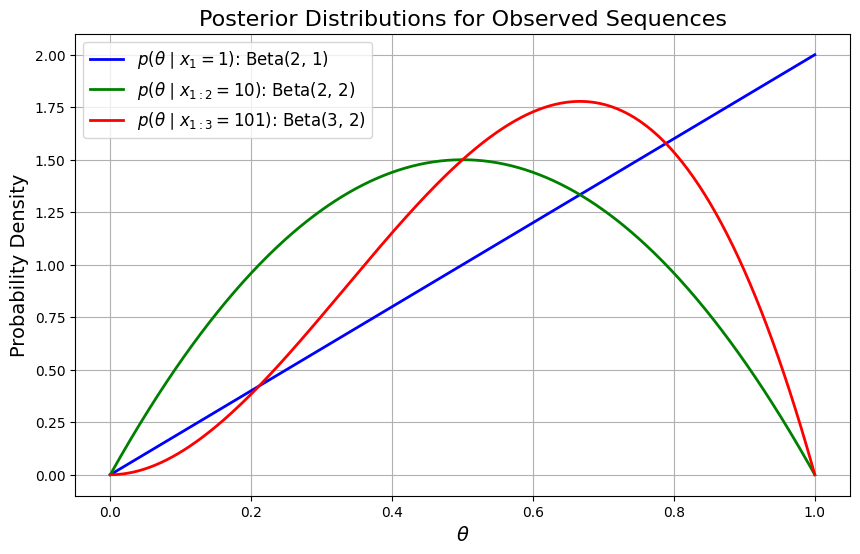

In [30]:


# Define theta values for plotting (bias of the coin)
theta = np.linspace(0, 1, 500)

# Define the Beta distributions based on the derived posterior parameters
pdf_beta_2_1 = beta.pdf(theta, 2, 1)   # For p(θ | x1 = 1)
pdf_beta_2_2 = beta.pdf(theta, 2, 2)   # For p(θ | x1:2 = 10)
pdf_beta_3_2 = beta.pdf(theta, 3, 2)   # For p(θ | x1:3 = 101)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(theta, pdf_beta_2_1, label=r'$p(\theta \mid x_1 = 1)$: Beta(2, 1)', color='blue', linewidth=2)
plt.plot(theta, pdf_beta_2_2, label=r'$p(\theta \mid x_{1:2} = 10)$: Beta(2, 2)', color='green', linewidth=2)
plt.plot(theta, pdf_beta_3_2, label=r'$p(\theta \mid x_{1:3} = 101)$: Beta(3, 2)', color='red', linewidth=2)

# Add labels, title, and legend
plt.xlabel(r'$\theta$', fontsize=14)
plt.ylabel('Probability Density', fontsize=14)
plt.title('Posterior Distributions for Observed Sequences', fontsize=16)
plt.legend(fontsize=12)
plt.grid()

# Display the plot
plt.show()


f) What behaviour would you expect of the posterior distribution $p(\theta|x_{1:n})$ if we updated on a very long sequence of alternating coin ﬂips $x_{1:n}=1010101010\dots$? Hint: You can try to plot the distributions for n=1,2,3,4,5… and find the trend/behaviour by intuition.

## Behavior of Posterior Distribution with Alternating Coin Flips

Let’s analyze the behavior of the posterior distribution $ p(\theta \mid x_{1:n}) $ when we observe a very long sequence of alternating coin flips:

$$
x_{1:n} = 1010101010\ldots
$$

### 1. Symmetric Posterior
Since the sequence contains an equal number of heads (1s) and tails (0s), the posterior distribution $ p(\theta \mid x_{1:n}) $ is expected to be symmetric around $\theta = 0.5$. This symmetry arises because the evidence for heads and tails is balanced, suggesting that the coin is fair.

### 2. Increasing Sharpness
As the length of the sequence $ n $ increases, the posterior distribution becomes more concentrated (sharper) around $\theta = 0.5$. This behavior indicates increasing confidence that the true value of $\theta$ is $0.5$, suggesting that the coin is fair.

### 3. Convergence to $\text{Beta}(\alpha, \beta)$ with $\alpha \approx \beta$
For an alternating sequence of length $ n $:
- The number of heads (1s) is approximately $\frac{n}{2}$.
- The number of tails (0s) is also approximately $\frac{n}{2}$.
- This results in a posterior distribution given by:

$$
p(\theta \mid x_{1:n}) = \text{Beta}\left(\frac{n}{2} + 1, \frac{n}{2} + 1\right)
$$

This distribution is symmetric around $\theta = 0.5$.

### 4. Trend Observation
- For small $ n $, the posterior distribution is wide, reflecting greater uncertainty about the true value of $\theta$.
- As $ n $ increases, the posterior distribution becomes narrower and peaks around $\theta = 0.5$, indicating increased confidence that the coin is fair.


In summary, as we observe a very long sequence of alternating coin flips, the posterior distribution $ p(\theta \mid x_{1:n}) $ converges to a sharp peak at $\theta = 0.5$, reflecting a strong belief that the coin has no bias and is fair.


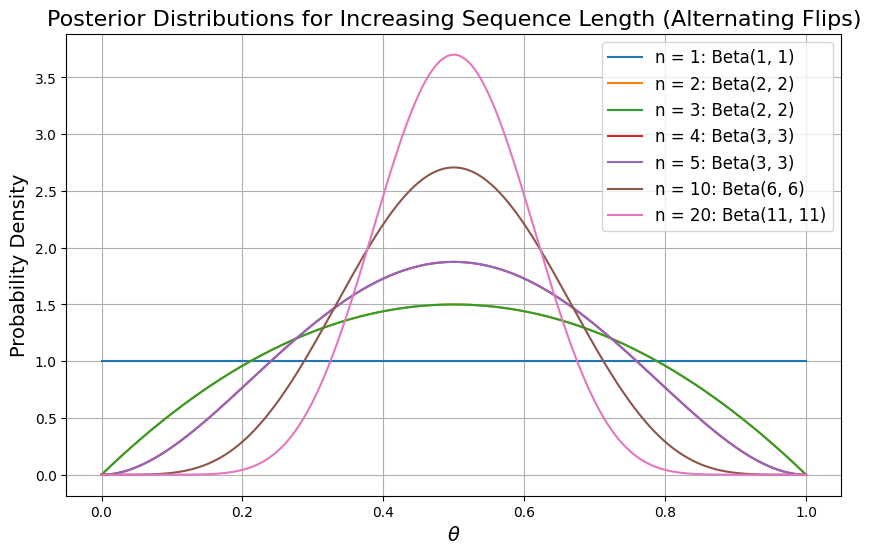

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import beta

# Define theta values for plotting
theta = np.linspace(0, 1, 500)

# Define a list of n values for the alternating sequence
n_values = [1, 2, 3, 4, 5, 10, 20]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the posterior for each n value
for n in n_values:
    alpha = (n // 2) + 1
    beta_param = (n // 2) + 1
    pdf = beta.pdf(theta, alpha, beta_param)
    plt.plot(theta, pdf, label=f'n = {n}: Beta({alpha}, {beta_param})')

# Add labels, title, and legend
plt.xlabel(r'$\theta$', fontsize=14)
plt.ylabel('Probability Density', fontsize=14)
plt.title('Posterior Distributions for Increasing Sequence Length (Alternating Flips)', fontsize=16)
plt.legend(fontsize=12)
plt.grid()

# Display the plot
plt.show()


# **Problem 3: Overcomplete sparse presentation**



I) Write the code that applies LDA and cosine scoring to the I-vectors provided in /data/.

In [25]:
def load_ivectors_from_folder_with_labels(folder_path):
    data = {'Train': {'ivectors': [], 'labels': []},
            'Dev': {'ivectors': [], 'labels': []},
            'Eval': {'ivectors': [], 'labels': []}}

    for folder in ['Train', 'Dev', 'Eval']:
        folder_full_path = os.path.join(folder_path, folder)

        for file_name in os.listdir(folder_full_path):
            if file_name.endswith('.txt'):
                file_path = os.path.join(folder_full_path, file_name)

                ivectors = np.loadtxt(file_path)

                class_label = int(file_name.split('_')[1].split('.')[0]) - 1  # Subtract 1 to make it 0-indexed

                data[folder]['ivectors'].append(ivectors)
                data[folder]['labels'].append(np.full(len(ivectors), class_label))

    for folder in ['Train', 'Dev', 'Eval']:
        data[folder]['ivectors'] = np.vstack(data[folder]['ivectors'])
        data[folder]['labels'] = np.concatenate(data[folder]['labels'])

    return data

In [34]:
folder_path = "/content/drive/MyDrive/lab6/HW3_data/HW3_Problem_3"
data = load_ivectors_from_folder_with_labels(folder_path)

train_ivectors = data['Train']['ivectors']
train_labels = data['Train']['labels']

dev_ivectors = data['Dev']['ivectors']
dev_labels = data['Dev']['labels']

eval_ivectors = data['Eval']['ivectors']
eval_labels = data['Eval']['labels']

print(f"Loaded {len(train_ivectors)} training I-vectors with {len(np.unique(train_labels))} unique classes")
print(f"Loaded {len(dev_ivectors)} development I-vectors with {len(np.unique(dev_labels))} unique classes")
print(f"Loaded {len(eval_ivectors)} evaluation I-vectors with {len(np.unique(eval_labels))} unique classes")

Loaded 22491 training I-vectors with 24 unique classes
Loaded 2400 development I-vectors with 24 unique classes
Loaded 2400 evaluation I-vectors with 24 unique classes


In [35]:
def custom_lda(X, y, num_classes):
    n_features = X.shape[1]
    mean_total = np.mean(X, axis=0)

    S_w = np.zeros((n_features, n_features))
    S_b = np.zeros((n_features, n_features))

    for c in range(num_classes):
        class_samples = X[y == c]
        mean_class = np.mean(class_samples, axis=0)

        # Within-class scatter
        S_w += np.dot((class_samples - mean_class).T, (class_samples - mean_class))

        # Between-class scatter
        n_c = class_samples.shape[0]
        mean_diff = (mean_class - mean_total).reshape(-1, 1)
        S_b += n_c * np.dot(mean_diff, mean_diff.T)

    S_w += 1e-6 * np.eye(n_features)

    eigvals, eigvecs = np.linalg.eig(np.linalg.inv(S_w).dot(S_b))

    eigvals = np.real(eigvals)
    eigvecs = np.real(eigvecs)

    sorted_indices = np.argsort(eigvals)[::-1]
    eigvecs = eigvecs[:, sorted_indices]

    lda_matrix = eigvecs[:, :num_classes - 1]
    return lda_matrix

In [36]:
num_classes = 24  # Number of language classes
lda_matrix = custom_lda(train_ivectors, train_labels, num_classes)

X_train_lda = np.dot(train_ivectors, lda_matrix)
print(f"LDA Transformed Training Data Shape: {X_train_lda.shape}")

LDA Transformed Training Data Shape: (22491, 23)


In [37]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def evaluate_cosine_scoring(ivectors, labels, lda_matrix, train_vectors, train_labels):
    ivectors_lda = np.dot(ivectors, lda_matrix)
    similarities = cosine_similarity(ivectors_lda, train_vectors)
    best_match_idx = np.argmax(similarities, axis=1)

    predicted_labels = train_labels[best_match_idx]
    accuracy = np.mean(predicted_labels == labels) * 100
    return accuracy

In [38]:
# Transform the training, dev, and eval sets using the LDA matrix
dev_ivectors_lda = np.dot(dev_ivectors, lda_matrix)
eval_ivectors_lda = np.dot(eval_ivectors, lda_matrix)

# Evaluate on Dev and Eval sets
dev_accuracy = evaluate_cosine_scoring(dev_ivectors, dev_labels, lda_matrix, X_train_lda, train_labels)
eval_accuracy = evaluate_cosine_scoring(eval_ivectors, eval_labels, lda_matrix, X_train_lda, train_labels)

print(f"Development Set Accuracy (LDA + Cosine): {dev_accuracy:.2f}%")
print(f"Evaluation Set Accuracy (LDA + Cosine): {eval_accuracy:.2f}%")

Development Set Accuracy (LDA + Cosine): 85.88%
Evaluation Set Accuracy (LDA + Cosine): 70.29%


II) Write the code that classifier the I-vector   based on overcomplete space representation


In [70]:
def create_class_matrices(ivectors, labels, num_classes):
    """
    Create class-specific matrices D_c and concatenate them to form the dictionary matrix A.

    Parameters:
        ivectors (ndarray): Training I-vectors of shape (n_samples, n_features).
        labels (ndarray): Training labels of shape (n_samples,).
        num_classes (int): Number of classes.

    Returns:
        A (ndarray): Dictionary matrix of shape (n_features, total_samples).
        class_matrices (list): List of class-specific matrices [D_1, ..., D_C].
    """
    class_matrices = []

    for c in range(num_classes):
        # Extract rows corresponding to the current class
        class_ivectors = ivectors[labels == c].T  # Transpose to make columns correspond to I-vectors
        class_matrices.append(class_ivectors)

    # Concatenate all class-specific matrices to form A
    A = np.hstack(class_matrices)  # Horizontal concatenation
    return A, class_matrices

# Example usage
num_classes = 24
A, D_matrices = create_class_matrices(train_ivectors,train_labels, num_classes)

print(f"Dictionary Matrix Shape (A): {A.shape}")
print(f"Number of Class Matrices: {len(D_matrices)}")

Dictionary Matrix Shape (A): (600, 22491)
Number of Class Matrices: 24


In [71]:
def sparse_coding(A, x, alpha_lambda=0.1):
    """
    Perform sparse coding using Lasso regression.

    Parameters:
        A (ndarray): Dictionary matrix of shape (n_features, n_atoms).
        x (ndarray): Test I-vector of shape (n_features,).
        alpha_lambda (float): Regularization parameter for Lasso.

    Returns:
        alpha (ndarray): Sparse weight vector of shape (n_atoms,).
    """
    lasso = Lasso(alpha=alpha_lambda, fit_intercept=False, max_iter=100)
    lasso.fit(A, x)
    return lasso.coef_

def classify_overcomplete(A, test_ivectors, D_matrices, num_classes, alpha_lambda=0.1):
    """
    Classify I-vectors based on overcomplete sparse representation.

    Parameters:
        A (ndarray): Dictionary matrix of shape (n_features, n_atoms).
        test_ivectors (ndarray): Test I-vectors of shape (n_samples, n_features).
        D_matrices (list): List of class matrices [D_1, D_2, ..., D_C].
        num_classes (int): Number of language classes.
        alpha_lambda (float): Regularization parameter for Lasso.

    Returns:
        predicted_labels (ndarray): Predicted labels for test I-vectors.
    """
    predicted_labels = []
    n_samples = len(test_ivectors)

    # Initialize progress tracking milestones
    milestones = [int(n_samples * (i / 10)) for i in range(1, 11)]
    next_milestone = milestones.pop(0) if milestones else None

    for i, x in enumerate(test_ivectors):
        # Sparse coding for the test vector
        alpha = sparse_coding(A, x, alpha_lambda)

        # Compute reconstruction error for each class
        errors = []
        start_idx = 0
        for c in range(num_classes):
            D_c = D_matrices[c]
            n_atoms = D_c.shape[1]
            alpha_c = alpha[start_idx : start_idx + n_atoms]
            reconstruction = np.dot(D_c, alpha_c)
            error = np.linalg.norm(x - reconstruction) ** 2
            errors.append(error)
            start_idx += n_atoms

        # Assign the test vector to the class with the smallest error
        predicted_labels.append(np.argmin(errors))

        # Print progress at each 10% completion
        if next_milestone and i >= next_milestone:
            progress = (i + 1) / n_samples * 100
            print(f"Progress: {progress:.1f}% completed")
            next_milestone = milestones.pop(0) if milestones else None

    return np.array(predicted_labels)


In [72]:
# Classify Dev I-Vectors
dev_predicted_labels = classify_overcomplete(A, dev_ivectors, D_matrices, num_classes)
dev_accuracy = np.mean(dev_predicted_labels == dev_labels) * 100

# Classify Eval I-Vectors
eval_predicted_labels = classify_overcomplete(A, eval_ivectors, D_matrices, num_classes)
eval_accuracy = np.mean(eval_predicted_labels == eval_labels) * 100

print(f"Development Set Accuracy (Overcomplete + LDA): {dev_accuracy:.2f}%")
print(f"Evaluation Set Accuracy (Overcomplete + LDA): {eval_accuracy:.2f}%")

Progress: 10.0% completed
Progress: 20.0% completed
Progress: 30.0% completed
Progress: 40.0% completed
Progress: 50.0% completed
Progress: 60.0% completed
Progress: 70.0% completed
Progress: 80.0% completed
Progress: 90.0% completed
Progress: 10.0% completed
Progress: 20.0% completed
Progress: 30.0% completed
Progress: 40.0% completed
Progress: 50.0% completed
Progress: 60.0% completed
Progress: 70.0% completed
Progress: 80.0% completed
Progress: 90.0% completed
Development Set Accuracy (Overcomplete + LDA): 64.12%
Evaluation Set Accuracy (Overcomplete + LDA): 29.38%


III) In this question, please redo the same process as question (I) after projecting first all the I-vectors by LDA, which was trained in question (I). Evaluate again the recognition accuracy rates for both Dev and Eval directories? If both accuracies are better than question (II), explain why?

In [42]:
# Train LDA
lda_matrix = custom_lda(train_ivectors,train_labels, num_classes)

# Transform all I-vectors using LDA
X_train_lda = np.dot(train_ivectors, lda_matrix)
dev_ivectors_lda = np.dot(dev_ivectors, lda_matrix)
eval_ivectors_lda = np.dot(eval_ivectors, lda_matrix)

# Transform the dictionary matrix A into the LDA space
A_lda, D_matrices_lda = create_class_matrices(X_train_lda, train_labels, num_classes)

print(f"LDA-Transformed Dictionary Matrix Shape: {A_lda.shape}")

LDA-Transformed Dictionary Matrix Shape: (23, 22491)


In [43]:
# Classify Dev I-Vectors
dev_predicted_labels = classify_overcomplete(A_lda, dev_ivectors_lda, D_matrices_lda, num_classes)
dev_accuracy = np.mean(dev_predicted_labels == dev_labels) * 100

# Classify Eval I-Vectors
eval_predicted_labels = classify_overcomplete(A_lda, eval_ivectors_lda, D_matrices_lda, num_classes)
eval_accuracy = np.mean(eval_predicted_labels == eval_labels) * 100

print(f"Development Set Accuracy (Overcomplete + LDA): {dev_accuracy:.2f}%")
print(f"Evaluation Set Accuracy (Overcomplete + LDA): {eval_accuracy:.2f}%")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.637e-03, tolerance: 1.311e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.834e-03, tolerance: 8.076e-04
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.077e-03, tolerance: 1.422e

Progress: 10.0% completed


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.591e-02, tolerance: 2.724e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.407e-03, tolerance: 1.070e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.029e-02, tolerance: 2.110e

Progress: 20.0% completed


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.751e-02, tolerance: 3.057e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.559e-02, tolerance: 2.321e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.667e-02, tolerance: 4.741e

Progress: 30.0% completed


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.046e-01, tolerance: 2.809e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.952e-03, tolerance: 1.500e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.063e-02, tolerance: 2.240e

Progress: 40.0% completed


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.232e-02, tolerance: 2.537e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.709e-02, tolerance: 2.034e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.885e-02, tolerance: 2.799e

Progress: 50.0% completed


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.517e-02, tolerance: 1.552e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.265e-02, tolerance: 1.845e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.727e-03, tolerance: 1.969e

Progress: 60.0% completed


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.927e-03, tolerance: 2.218e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.019e-03, tolerance: 1.811e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.877e-03, tolerance: 9.708e

Progress: 70.0% completed


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.050e-02, tolerance: 2.210e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.061e-02, tolerance: 2.935e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.600e-03, tolerance: 1.611e

Progress: 80.0% completed


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.174e-02, tolerance: 1.792e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.318e-02, tolerance: 2.169e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.959e-03, tolerance: 1.911e

Progress: 90.0% completed


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.072e-02, tolerance: 2.294e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.418e-02, tolerance: 1.379e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.132e-02, tolerance: 2.007e

Progress: 10.0% completed


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.599e-02, tolerance: 1.493e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.145e-02, tolerance: 1.141e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.245e-02, tolerance: 2.206e

Progress: 20.0% completed


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.065e-03, tolerance: 7.084e-04
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.121e-03, tolerance: 1.517e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.240e-03, tolerance: 1.508e

Progress: 30.0% completed


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.494e-02, tolerance: 2.117e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.093e-01, tolerance: 2.013e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.271e-02, tolerance: 3.496e

Progress: 40.0% completed


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.077e-02, tolerance: 1.672e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.339e-02, tolerance: 2.038e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.247e-02, tolerance: 2.491e

Progress: 50.0% completed


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.940e-03, tolerance: 2.022e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.602e-02, tolerance: 3.508e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.911e-03, tolerance: 1.384e

Progress: 60.0% completed


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.682e-02, tolerance: 1.724e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.249e-02, tolerance: 2.228e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.608e-03, tolerance: 1.974e

Progress: 70.0% completed


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.233e-02, tolerance: 2.096e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.027e-02, tolerance: 8.109e-04
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.436e-03, tolerance: 9.142e

Progress: 80.0% completed


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.892e-03, tolerance: 1.544e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.862e-02, tolerance: 3.604e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.353e-03, tolerance: 1.162e

Progress: 90.0% completed


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.549e-01, tolerance: 4.325e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.989e-02, tolerance: 2.484e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.562e-02, tolerance: 1.902e

Development Set Accuracy (Overcomplete + LDA): 84.38%
Evaluation Set Accuracy (Overcomplete + LDA): 70.50%


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.770e-03, tolerance: 1.418e-03
  model = cd_fast.enet_coordinate_descent(


IV) To speed up the process, train a code book using k-means for each language class with k=55. Each language will be only represented by 55 centroids. The classes that have already 55 I-vectors take all of them (do not apply kmeans). For kmeans implementation used the function already predefines in Matlab. Apply the overcomplete space representation classification again. Similar to question III use the after projecting first all of them by LDA

In [54]:
# Step 1: K-means clustering to create codebook with 55 centroids per class
def create_centroid_matrices(ivectors, labels, num_classes, n_centroids=55):
    centroid_matrices = []
    for c in range(num_classes):
        class_ivectors = ivectors[labels == c]
        if class_ivectors.shape[0] <= n_centroids:
            # If the class has <= 55 I-vectors, use all as centroids
            centroids = class_ivectors
        else:
            # Otherwise, apply K-means clustering to get 55 centroids
            kmeans = KMeans(n_clusters=n_centroids, random_state=0)
            kmeans.fit(class_ivectors)
            centroids = kmeans.cluster_centers_
        centroid_matrices.append(centroids.T)  # Transpose for concatenation in dictionary
    return np.hstack(centroid_matrices), centroid_matrices  # Full dictionary and list of centroids


In [55]:
# Step 2: Project data using LDA
def apply_lda_projection(ivectors, labels, num_classes):
    lda = LinearDiscriminantAnalysis(n_components=num_classes - 1)
    ivectors_lda = lda.fit_transform(ivectors, labels)
    return ivectors_lda, lda


In [56]:
# Step 3: Sparse coding with Lasso regression
def sparse_coding(A, x, alpha_lambda=0.1):
    lasso = Lasso(alpha=alpha_lambda, fit_intercept=False, max_iter=1000)
    lasso.fit(A, x)
    return lasso.coef_


In [57]:
# Step 4: Classify based on reconstruction error with 10% progress tracking
def classify_overcomplete(A, test_ivectors, D_matrices, num_classes, alpha_lambda=0.1):
    predicted_labels = []
    total_samples = len(test_ivectors)

    # Initialize progress tracking
    milestones = [int(total_samples * (i / 10)) for i in range(1, 11)]
    next_milestone = milestones.pop(0) if milestones else None

    for idx, x in enumerate(test_ivectors):
        # Sparse coding for the test vector
        alpha = sparse_coding(A, x, alpha_lambda)

        # Compute reconstruction error for each class
        errors = []
        start_idx = 0
        for c in range(num_classes):
            D_c = D_matrices[c]
            n_atoms = D_c.shape[1]
            alpha_c = alpha[start_idx : start_idx + n_atoms]
            reconstruction = D_c @ alpha_c
            error = np.linalg.norm(x - reconstruction) ** 2
            errors.append(error)
            start_idx += n_atoms

        # Assign the test vector to the class with the smallest error
        predicted_labels.append(np.argmin(errors))

        # Progress update every 10%
        if next_milestone and idx >= next_milestone:
            progress = (idx + 1) / total_samples * 100
            print(f"Progress: {progress:.1f}% completed")
            next_milestone = milestones.pop(0) if milestones else None

    return np.array(predicted_labels)
num_classes = 24
n_centroids = 55  # Desired number of centroids per class

# Assume train_ivectors, train_labels, dev_ivectors, dev_labels, eval_ivectors, eval_labels are loaded

# Step 1: Create centroids for each class and form the dictionary matrix A
A, D_matrices = create_centroid_matrices(train_ivectors, train_labels, num_classes, n_centroids=n_centroids)



In [58]:
# Step 2: Apply LDA to training, dev, and eval sets
train_ivectors_lda, lda = apply_lda_projection(train_ivectors, train_labels, num_classes)
dev_ivectors_lda = lda.transform(dev_ivectors)
eval_ivectors_lda = lda.transform(eval_ivectors)


In [59]:
# Step 3: Re-create the dictionary matrix A and D_matrices after LDA projection
A_lda, D_matrices_lda = create_centroid_matrices(train_ivectors_lda, train_labels, num_classes, n_centroids=n_centroids)
# Step 4: Classify the projected dev and eval sets
dev_predicted_labels = classify_overcomplete(A_lda, dev_ivectors_lda, D_matrices_lda, num_classes)
eval_predicted_labels = classify_overcomplete(A_lda, eval_ivectors_lda, D_matrices_lda, num_classes)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.789e-03, tolerance: 4.426e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.384e-02, tolerance: 1.062e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.325e-02, tolerance: 1.094e

Progress: 10.0% completed


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.132e-02, tolerance: 7.819e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.824e-03, tolerance: 8.598e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.886e-02, tolerance: 1.354e

Progress: 20.0% completed


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.452e-03, tolerance: 6.319e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.689e-02, tolerance: 1.122e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.015e-02, tolerance: 1.108e

Progress: 30.0% completed


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.389e-03, tolerance: 7.957e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.197e-02, tolerance: 8.808e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.440e-02, tolerance: 1.114e

Progress: 40.0% completed


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.365e-02, tolerance: 1.657e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.715e-02, tolerance: 1.149e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.384e-02, tolerance: 1.254e

Progress: 50.0% completed


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.071e-02, tolerance: 1.558e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.372e-02, tolerance: 1.084e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.943e-02, tolerance: 1.014e

Progress: 60.0% completed


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.383e-03, tolerance: 2.611e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.995e-03, tolerance: 6.298e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.534e-03, tolerance: 3.142e

Progress: 70.0% completed


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.435e-03, tolerance: 7.946e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.371e-03, tolerance: 8.117e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.269e-03, tolerance: 4.108e

Progress: 80.0% completed


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.070e-03, tolerance: 4.094e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.071e-02, tolerance: 9.165e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.695e-02, tolerance: 5.980e

Progress: 90.0% completed


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.299e-02, tolerance: 6.844e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.286e-02, tolerance: 9.614e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.745e-03, tolerance: 4.318e

Progress: 10.0% completed


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.515e-02, tolerance: 1.150e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.088e-02, tolerance: 1.410e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.168e-03, tolerance: 6.260e

Progress: 20.0% completed


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.730e-03, tolerance: 4.232e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.534e-02, tolerance: 1.089e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.826e-03, tolerance: 3.652e

Progress: 30.0% completed


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.200e-03, tolerance: 3.940e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.324e-02, tolerance: 1.118e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.674e-03, tolerance: 4.331e

Progress: 40.0% completed


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.744e-02, tolerance: 1.635e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.867e-02, tolerance: 9.603e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.038e-02, tolerance: 1.699e

Progress: 50.0% completed


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.191e-02, tolerance: 5.018e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.532e-03, tolerance: 3.866e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.517e-03, tolerance: 4.093e

Progress: 60.0% completed


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.928e-02, tolerance: 1.066e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.042e-02, tolerance: 9.645e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.329e-02, tolerance: 3.774e

Progress: 70.0% completed


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.451e-03, tolerance: 5.413e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.138e-02, tolerance: 6.833e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.675e-02, tolerance: 1.199e

Progress: 80.0% completed


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.049e-02, tolerance: 5.189e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.497e-02, tolerance: 7.881e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.111e-02, tolerance: 8.825e

Progress: 90.0% completed


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.187e-02, tolerance: 1.012e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.247e-02, tolerance: 1.163e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.054e-03, tolerance: 5.869e

In [60]:
# Step 5: Calculate accuracy
acc_dev = accuracy_score(dev_labels, dev_predicted_labels)
acc_eval = accuracy_score(eval_labels, eval_predicted_labels)

print(f"Accuracy (Dev): {acc_dev * 100:.2f}%")
print(f"Accuracy (Eval): {acc_eval * 100:.2f}%")


Accuracy (Dev): 81.71%
Accuracy (Eval): 68.54%


V) Apply Gaussian classifier as it will be seen in the class for this task with the assumption of equal prior for all the language classes and shared covariance between all the classes. In this part use the original I-vector of dimension 600. Compare your results with previous ones.

In [47]:
# Step 1: Calculate mean vectors for each class
def calculate_class_means(ivectors, labels, num_classes):
    class_means = []
    for c in range(num_classes):
        class_ivectors = ivectors[labels == c]
        class_mean = np.mean(class_ivectors, axis=0)
        class_means.append(class_mean)
    return np.array(class_means)


In [48]:
# Step 2: Calculate shared covariance matrix
def calculate_shared_covariance(ivectors, labels, class_means, num_classes):
    n_features = ivectors.shape[1]
    shared_cov = np.zeros((n_features, n_features))

    for c in range(num_classes):
        class_ivectors = ivectors[labels == c]
        diff = class_ivectors - class_means[c]
        shared_cov += diff.T @ diff  # Sum of covariance contributions

    # Divide by total number of samples to get the pooled covariance
    total_samples = ivectors.shape[0]
    shared_cov /= total_samples
    return shared_cov


In [49]:
num_classes = 24  # Number of language classes

# Step 1: Calculate class means using training data
class_means = calculate_class_means(train_ivectors, train_labels, num_classes)


In [50]:
# Step 2: Calculate shared covariance matrix
shared_cov = calculate_shared_covariance(train_ivectors, train_labels, class_means, num_classes)


In [51]:
# Step 3: Predict labels for development and evaluation sets
dev_predicted_labels = gaussian_classifier(dev_ivectors, class_means, shared_cov, num_classes)
eval_predicted_labels = gaussian_classifier(eval_ivectors, class_means, shared_cov, num_classes)

# Step 4: Calculate and print accuracy
acc_dev = accuracy_score(dev_labels, dev_predicted_labels)
acc_eval = accuracy_score(eval_labels, eval_predicted_labels)

print(f"Gaussian Classifier Accuracy (Dev): {acc_dev * 100:.2f}%")
print(f"Gaussian Classifier Accuracy (Eval): {acc_eval * 100:.2f}%")


Gaussian Classifier Accuracy (Dev): 83.67%
Gaussian Classifier Accuracy (Eval): 70.54%


**You are ready to submit in Canvas!**

4 easy steps to submit your lab:

1.   Go to "File" - Download ".ipynb" and ".py"
2.   Click on "Share" option on top right - Click on "copy link" option. Make sure your permission is set to "Anyone on the internet with this link can view"
3.   Upload the ".ipynb" file obtained from Step (1) as instructed in the homework document. If it is too big, zip it before uploading.
4.   In the text comments on Canvas, paste the link obtained from Step (3).

That's it!

In short, we want to have one link, one .ipynb, one ".py" and one 'HW3_yourJHID.zip' containing all the required outputs.

Please suffix your colab file and the zip file with your _jhID, eg: HW3_myjhID12
